In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.externals import joblib

%matplotlib inline

### Import model and files

In [2]:
## define what's needed for model to load

from sklearn.base import BaseEstimator, TransformerMixin

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column    
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        return X[self.column].values

In [3]:
# load up the 
filename = 'logreg_ppg.pkl'
pipeline = pickle.load(open(filename, 'rb'))

In [106]:
## import files needed
model_df = pd.read_csv('./data/model_df.csv')
pred_full = pd.read_csv('./data/pred_full.csv')
pred_full.head()

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas
0,0,1989.0kareem abdul-jabbar,kareem abdul-jabbar,0,C,41.0,74.0,74.0,1695.0,12.9,...,1.391892,3.121622,4.513514,1.000000,0.513514,1.148649,1.283784,2.648649,10.108108,0.004268
1,0,1989.0mark acres,mark acres,0,C,26.0,62.0,0.0,632.0,8.2,...,0.951613,1.403226,2.354839,0.306452,0.306452,0.096774,0.370968,1.516129,2.209677,0.000021
2,0,1989.0michael adams,michael adams,0,PG,26.0,77.0,77.0,2787.0,17.5,...,0.922078,2.753247,3.675325,6.363636,2.155844,0.142857,2.337662,1.935065,18.493506,0.010129
3,0,1989.0mark aguirre,mark aguirre,0,SF,29.0,80.0,76.0,2597.0,16.4,...,1.825000,3.000000,4.825000,3.475000,0.562500,0.450000,2.600000,2.862500,18.887500,0.003385
4,0,1989.0danny ainge,danny ainge,0,PG,29.0,73.0,54.0,2377.0,18.0,...,0.972603,2.520548,3.493151,5.506849,1.273973,0.109589,1.986301,2.547945,17.547945,0.004648


In [107]:
pred_full['year'] = pred_full['year-player'].apply(lambda x: float(x[:4]))

### Need to re-do the predicted dataframe for the whole dataset now
- Have the workflow from previous notebook

In [108]:
pred_names = pd.DataFrame()

for year in pred_full['year'].unique():
    for pos in model_df.award_pos.unique():
        
        maskyear = year
        maskpos = pos

        mask = (pred_full['pos_encode_'+maskpos] == 1) & (pred_full['year'] == maskyear)
        
        
        ## control flow:
        if maskpos != 'C':
        
            pred_names = pred_names.append(pred_full.loc[mask, ['year', 'player', 'probas', 'target']].sort_values(by='probas', ascending=False).head(6))
                    
        else:
            pred_names = pred_names.append(pred_full.loc[mask, ['year', 'player', 'probas', 'target']].sort_values(by='probas', ascending=False).head(3))

        
pred_names = pred_names.reset_index(drop=True)

## comment
pred_award_pos = [1, 2, 3, 1, 1, 2, 2, 3, 3, 1, 1, 2, 2, 3, 3] * pred_names.year.nunique()
pred_names['pred_award_tm'] = pred_award_pos


## comment
pred_names['year-player'] = pred_names['year'].astype(str) + pred_names['player']
pred_names['predicted'] = 1

pred_names = pd.merge(pred_names, model_df[['year-player', 'award_pos']], how='left', on='year-player')

pred_names.head(15)

,year,player,probas,target,pred_award_tm,year-player,predicted,award_pos
0,1989.0,hakeem olajuwon,0.993966,1,1,1989.0hakeem olajuwon,1,C
1,1989.0,patrick ewing,0.741323,1,2,1989.0patrick ewing,1,C
2,1989.0,moses malone,0.719781,0,3,1989.0moses malone,1,C
3,1989.0,michael jordan,0.999682,1,1,1989.0michael jordan,1,G
4,1989.0,magic johnson,0.989883,1,1,1989.0magic johnson,1,G
5,1989.0,john stockton,0.981688,1,2,1989.0john stockton,1,G
6,1989.0,dale ellis,0.933171,1,2,1989.0dale ellis,1,G
7,1989.0,clyde drexler,0.886493,0,3,1989.0clyde drexler,1,G
8,1989.0,kevin johnson,0.630598,1,3,1989.0kevin johnson,1,G
9,1989.0,karl malone,0.997444,1,1,1989.0karl malone,1,F


In [4]:
## save it!
# pred_names.to_csv('./data/pred_names_FINAL.csv', index=False)
pred_names = pd.read_csv('./data/pred_names_FINAL.csv')

Yippee!! Now we have a full prediction set. Time to re-append to `pred_full` to do analysis, and also to keep!

In [110]:
pred_full[(pred_full['year'] == 2000) & (pred_full['target'] > 0)].head()

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year
2858,1,2000.0kobe bryant,kobe bryant,2,SG,21.0,66.0,62.0,2524.0,21.7,...,4.666667,6.303030,4.893939,1.606061,0.939394,2.757576,3.333333,22.500000,0.913072,2000.0
2872,1,2000.0vince carter,vince carter,3,SF,23.0,82.0,82.0,3126.0,23.4,...,3.975610,5.804878,3.926829,1.341463,1.121951,2.170732,3.207317,25.695122,0.870080,2000.0
2919,1,2000.0tim duncan,tim duncan,1,PF,23.0,74.0,74.0,2875.0,24.8,...,8.864865,12.405405,3.162162,0.891892,2.229730,3.270270,2.837838,23.189189,0.997186,2000.0
2942,1,2000.0kevin garnett,kevin garnett,1,PF,23.0,81.0,81.0,3243.0,23.6,...,9.049383,11.802469,4.950617,1.481481,1.555556,3.308642,2.530864,22.925926,0.922176,2000.0
2977,1,2000.0grant hill,grant hill,2,SF,27.0,74.0,74.0,2776.0,24.5,...,5.310811,6.621622,5.202703,1.391892,0.581081,3.243243,2.567568,25.756757,0.958184,2000.0


In [111]:
## merge it!
pred_full_merge = pd.merge(pred_full, pred_names[['year-player', 'award_pos', 'predicted', 'pred_award_tm']], 
         how='left', on='year-player').fillna(0)

In [112]:
pred_full_merge[(pred_full_merge['year'] == 2000) & (pred_full_merge['target'] > 0)].head()

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
2858,1,2000.0kobe bryant,kobe bryant,2,SG,21.0,66.0,62.0,2524.0,21.7,...,1.606061,0.939394,2.757576,3.333333,22.500000,0.913072,2000.0,G,1.0,1.0
2872,1,2000.0vince carter,vince carter,3,SF,23.0,82.0,82.0,3126.0,23.4,...,1.341463,1.121951,2.170732,3.207317,25.695122,0.870080,2000.0,F,1.0,3.0
2919,1,2000.0tim duncan,tim duncan,1,PF,23.0,74.0,74.0,2875.0,24.8,...,0.891892,2.229730,3.270270,2.837838,23.189189,0.997186,2000.0,F,1.0,1.0
2942,1,2000.0kevin garnett,kevin garnett,1,PF,23.0,81.0,81.0,3243.0,23.6,...,1.481481,1.555556,3.308642,2.530864,22.925926,0.922176,2000.0,F,1.0,3.0
2977,1,2000.0grant hill,grant hill,2,SF,27.0,74.0,74.0,2776.0,24.5,...,1.391892,0.581081,3.243243,2.567568,25.756757,0.958184,2000.0,F,1.0,2.0


In [5]:
## save it!
# pred_full_merge.to_csv('./data/pred_full_merge.csv', index=False)

## bop it
merged_full = pd.read_csv('./data/pred_full_merge.csv')

### Onto our analysis!

For some reason, the year 2000 is missing its `target` and `award_tm` data...

** Biggest Snubs**  
Needs a "so who got it instead?"

In [120]:
mask = (pred_full_merge['target'] == 0) & (pred_full_merge['predicted'] == 1)

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(8)

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
11658,0,1993.0shaquille o'neal,shaquille o'neal,0,C,20.0,81.0,81.0,3071.0,22.9,...,0.740741,3.530864,3.790123,3.962963,23.370370,0.994671,1993.0,C,1.0,2.0
8436,0,2016.0james harden,james harden,0,SG,26.0,82.0,82.0,3125.0,25.3,...,1.695122,0.621951,4.560976,2.792683,28.975610,0.966763,2016.0,G,1.0,2.0
9926,0,2001.0jerry stackhouse,jerry stackhouse,0,SG,26.0,80.0,80.0,3215.0,21.8,...,1.212500,0.675000,4.075000,2.000000,29.750000,0.944586,2001.0,G,1.0,2.0
5669,0,2008.0allen iverson,allen iverson,0,SG,32.0,82.0,82.0,3424.0,20.9,...,1.951220,0.146341,2.987805,1.329268,26.390244,0.936964,2008.0,G,1.0,2.0
4692,0,2006.0kevin garnett,kevin garnett,0,PF,29.0,76.0,76.0,2957.0,26.8,...,1.368421,1.407895,2.368421,2.710526,21.789474,0.931423,2006.0,F,1.0,3.0
78,0,1989.0clyde drexler,clyde drexler,0,SG,26.0,78.0,78.0,3064.0,23.6,...,2.730769,0.692308,3.205128,3.448718,27.217949,0.886493,1989.0,G,1.0,3.0
5508,0,2008.0chauncey billups,chauncey billups,0,PG,31.0,78.0,78.0,2522.0,23.6,...,1.294872,0.217949,2.051282,1.666667,16.974359,0.866341,2008.0,G,1.0,3.0
7181,0,2012.0derrick rose,derrick rose,0,PG,23.0,39.0,39.0,1375.0,23.0,...,0.897436,0.717949,3.051282,1.333333,21.846154,0.824353,2012.0,G,1.0,2.0


In [172]:
mask = (pred_full_merge['target'] == 0) & (pred_full_merge['predicted'] == 1)

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(8)\
[['year-player', 'per','ws','trb_per_game', 'ast_per_game', 'pts_per_game', 'probas']]

,year-player,per,ws,trb_per_game,ast_per_game,pts_per_game,probas
11658,1993.0shaquille o'neal,22.9,10.4,13.851852,1.876543,23.370370,0.994671
8436,2016.0james harden,25.3,13.3,6.109756,7.463415,28.975610,0.966763
9926,2001.0jerry stackhouse,21.8,9.2,3.937500,5.125000,29.750000,0.944586
5669,2008.0allen iverson,20.9,11.6,2.963415,7.146341,26.390244,0.936964
4692,2006.0kevin garnett,26.8,14.9,12.710526,4.052632,21.789474,0.931423
78,1989.0clyde drexler,23.6,12.6,7.884615,5.769231,27.217949,0.886493
5508,2008.0chauncey billups,23.6,13.5,2.717949,6.782051,16.974359,0.866341
7181,2012.0derrick rose,23.0,6.0,3.358974,7.871795,21.846154,0.824353


In [181]:
mask = (pred_full_merge['target'] == 1) & (pred_full_merge['year'] == 2016)

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(15)\
[['target','year-player', 'ws','trb_per_game', 'ast_per_game', 'pts_per_game', 'award_pos','probas']]

,target,year-player,ws,trb_per_game,ast_per_game,pts_per_game,award_pos,probas
8364,1,2016.0stephen curry,17.9,5.443038,6.670886,30.063291,G,0.999954
8711,1,2016.0russell westbrook,14.0,7.825000,10.425000,23.475000,G,0.999432
8385,1,2016.0kevin durant,14.5,8.180556,5.013889,28.180556,F,0.999405
8480,1,2016.0lebron james,13.6,7.434211,6.763158,25.263158,F,0.997946
8522,1,2016.0kawhi leonard,13.7,6.847222,2.583333,21.152778,F,0.977996
8607,1,2016.0chris paul,12.7,4.189189,9.972973,19.540541,G,0.926884
8500,1,2016.0deandre jordan,11.5,13.753247,1.168831,12.727273,C,0.849883
8380,1,2016.0andre drummond,7.4,14.790123,0.827160,16.222222,C,0.801095
8425,1,2016.0draymond green,11.1,9.493827,7.382716,13.962963,F,0.786398
8266,1,2016.0lamarcus aldridge,10.1,8.540541,1.486486,17.986486,F,0.784675


In [174]:
mask = (pred_full_merge['year'] == 2016)

pred_full_merge.loc[mask].sort_values(by='ws', ascending=False).head(8)\
[['year-player', 'per','ws','trb_per_game', 'ast_per_game', 'pts_per_game', 'probas']]

,year-player,per,ws,trb_per_game,ast_per_game,pts_per_game,probas
8364,2016.0stephen curry,31.5,17.9,5.443038,6.670886,30.063291,0.999954
8385,2016.0kevin durant,28.2,14.5,8.180556,5.013889,28.180556,0.999405
8711,2016.0russell westbrook,27.6,14.0,7.825000,10.425000,23.475000,0.999432
8522,2016.0kawhi leonard,26.0,13.7,6.847222,2.583333,21.152778,0.977996
8480,2016.0lebron james,27.5,13.6,7.434211,6.763158,25.263158,0.997946
8436,2016.0james harden,25.3,13.3,6.109756,7.463415,28.975610,0.966763
8607,2016.0chris paul,26.2,12.7,4.189189,9.972973,19.540541,0.926884
8532,2016.0kyle lowry,22.2,11.6,4.740260,6.415584,21.220779,0.669655


** Biggest "Cupcakes" **  
Needs a "so who should've gotten it?"

In [121]:
mask = (pred_full_merge['target'] == 1) & (pred_full_merge['predicted'] == 0)

pred_full_merge.loc[mask].sort_values(by='probas', ascending=True).head(8)

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
11813,1,2009.0carmelo anthony,carmelo anthony,3,SF,24.0,66.0,66.0,2277.0,19.0,...,1.136364,0.363636,3.015152,2.954545,22.787879,0.007532,2009.0,0,0.0,0.0
11678,1,1993.0drazen petrovic,drazen petrovic,3,SG,28.0,70.0,67.0,2660.0,17.3,...,1.342857,0.185714,2.914286,3.385714,22.342857,0.008645,1993.0,0,0.0,0.0
1826,1,1995.0dennis rodman,dennis rodman,3,PF,33.0,49.0,26.0,1568.0,16.6,...,0.632653,0.469388,2.000000,3.244898,7.122449,0.009262,1995.0,0,0.0,0.0
6895,1,2012.0tyson chandler,tyson chandler,3,C,29.0,62.0,62.0,2061.0,18.7,...,0.903226,1.435484,1.645161,3.000000,11.274194,0.016848,2012.0,0,0.0,0.0
2670,1,1998.0scottie pippen,scottie pippen,3,SF,32.0,44.0,44.0,1652.0,20.4,...,1.795455,0.977273,2.477273,2.636364,19.113636,0.017044,1998.0,0,0.0,0.0
9294,1,1996.0juwan howard,juwan howard,3,PF,22.0,81.0,81.0,3294.0,17.0,...,0.827160,0.481481,3.740741,3.320988,22.086420,0.023642,1996.0,0,0.0,0.0
3048,1,2000.0stephon marbury,stephon marbury,3,PG,22.0,74.0,74.0,2881.0,20.7,...,1.513514,0.202703,3.648649,2.635135,22.162162,0.032085,2000.0,0,0.0,0.0
9832,1,2001.0dikembe mutombo,dikembe mutombo,2,C,34.0,75.0,75.0,2591.0,17.5,...,0.386667,2.706667,1.920000,2.720000,9.986667,0.049195,2001.0,0,0.0,0.0


In [171]:
mask = (pred_full_merge['target'] == 1) & (pred_full_merge['predicted'] == 0)

pred_full_merge.loc[mask].sort_values(by='probas', ascending=True).head(8)\
[['year-player', 'ws','trb_per_game', 'ast_per_game', 'pts_per_game', 'probas']]

,year-player,ws,trb_per_game,ast_per_game,pts_per_game,probas
11813,2009.0carmelo anthony,5.0,6.818182,3.363636,22.787879,0.007532
11678,1993.0drazen petrovic,8.4,2.714286,3.528571,22.342857,0.008645
1826,1995.0dennis rodman,5.8,16.795918,1.979592,7.122449,0.009262
6895,2012.0tyson chandler,9.5,9.870968,0.903226,11.274194,0.016848
2670,1998.0scottie pippen,6.6,5.159091,5.772727,19.113636,0.017044
9294,1996.0juwan howard,5.6,8.148148,4.444444,22.086420,0.023642
3048,2000.0stephon marbury,7.4,3.243243,8.405405,22.162162,0.032085
9832,2001.0dikembe mutombo,8.1,13.533333,1.013333,9.986667,0.049195


In [185]:
mask = (pred_full_merge['year'] == 2009)

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(18)\
[['target','year-player', 'ws','trb_per_game', 'ast_per_game', 'pts_per_game', 'probas']]

,target,year-player,ws,trb_per_game,ast_per_game,pts_per_game,probas
12004,1,2009.0lebron james,20.3,7.567901,7.246914,28.444444,0.999986
11987,1,2009.0dwight howard,13.8,13.835443,1.417722,20.556962,0.999585
12113,1,2009.0chris paul,18.3,5.538462,11.038462,22.833333,0.998415
12202,1,2009.0dwyane wade,14.7,5.037975,7.455696,30.202532,0.997638
11864,1,2009.0kobe bryant,12.7,5.231707,4.865854,26.841463,0.994685
11916,1,2009.0tim duncan,10.1,10.666667,3.520000,19.333333,0.978001
11942,1,2009.0pau gasol,13.9,9.629630,3.506173,18.864198,0.917034
12147,1,2009.0brandon roy,13.5,4.743590,5.128205,22.628205,0.903018
12099,1,2009.0dirk nowitzki,10.9,8.407407,2.432099,25.851852,0.835469
12112,1,2009.0tony parker,8.6,3.097222,6.888889,21.958333,0.788189


**Biggest Bridesmaid**  
Needs a "is there a year he should've made it?"

In [154]:
mask = (pred_full_merge['target'] == 0)

pred_full_merge.loc[mask, ['player', 'year', 'pts_per_game', 'probas', 'predicted','pred_award_tm']]\
.sort_values(by='probas', ascending=False).head(100).groupby('player').agg("count")\
.sort_values(by='year', ascending=False).head(8)

,year,pts_per_game,probas,predicted,pred_award_tm
player,,,,,
vince carter,3,3,3,3,3
patrick ewing,3,3,3,3,3
carmelo anthony,3,3,3,3,3
shawn marion,3,3,3,3,3
reggie miller,2,2,2,2,2
damian lillard,2,2,2,2,2
allen iverson,2,2,2,2,2
larry nance,2,2,2,2,2


In [155]:
mask = (pred_full_merge['target'] == 0)

pred_full_merge.loc[mask, ['player', 'year', 'pts_per_game', 'probas', 'predicted','pred_award_tm']]\
.sort_values(by='probas', ascending=False).head(100).groupby('player').agg("sum")\
.sort_values(by='probas', ascending=False).head(8)

,year,pts_per_game,probas,predicted,pred_award_tm
player,,,,,
patrick ewing,5985.0,70.930879,2.217277,0.0,0.0
vince carter,6018.0,73.927282,2.069940,2.0,6.0
carmelo anthony,6033.0,78.701299,1.675254,3.0,9.0
shawn marion,6011.0,56.051799,1.468598,1.0,3.0
alonzo mourning,3991.0,44.523377,1.328720,0.0,0.0
tony parker,4013.0,37.433442,1.311486,0.0,0.0
allen iverson,4012.0,52.765244,1.237465,2.0,5.0
brad daugherty,3982.0,39.079270,1.098749,0.0,0.0


In [139]:
## checking out Melo
mask = (pred_full_merge['target'] == 0) & (pred_full_merge['player'] == 'carmelo anthony')

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(3)

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
7305,0,2014.0carmelo anthony,carmelo anthony,0,PF,29.0,77.0,77.0,2982.0,24.4,...,1.233766,0.662338,2.571429,2.909091,27.428571,0.815980,2014.0,F,1.0,3.0
5481,0,2008.0carmelo anthony,carmelo anthony,0,SF,23.0,77.0,77.0,2806.0,21.1,...,1.272727,0.506494,3.285714,3.285714,25.688312,0.434489,2008.0,F,1.0,3.0
6374,0,2011.0carmelo anthony,carmelo anthony,0,SF,26.0,77.0,77.0,2751.0,21.7,...,0.883117,0.597403,2.675325,2.909091,25.584416,0.424784,2011.0,F,1.0,3.0


In [170]:
## checking out Matrix
mask = (pred_full_merge['target'] == 0) & (pred_full_merge['player'] == 'shawn marion')

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(3)

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
3916,0,2003.0shawn marion,shawn marion,0,SF,24.0,81.0,81.0,3373.0,21.3,...,2.283951,1.172840,1.938272,2.567901,21.185185,0.781586,2003.0,F,1.0,3.0
9789,0,2001.0shawn marion,shawn marion,0,SF,22.0,79.0,79.0,2857.0,21.0,...,1.670886,1.367089,1.632911,2.670886,17.329114,0.351111,2001.0,0,0.0,0.0
5263,0,2007.0shawn marion,shawn marion,0,SF,28.0,80.0,80.0,3010.0,20.8,...,1.950000,1.525000,1.425000,2.700000,17.537500,0.335902,2007.0,0,0.0,0.0


In [144]:
## checking out Patrick Ewing
mask = (pred_full_merge['target'] == 0) & (pred_full_merge['player'] == 'patrick ewing')

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(3)

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
1235,0,1994.0patrick ewing,patrick ewing,0,C,31.0,79.0,79.0,2972.0,22.9,...,1.139241,2.746835,3.291139,3.481013,24.544304,0.991980,1994.0,0,0.0,0.0
1633,0,1995.0patrick ewing,patrick ewing,0,C,32.0,79.0,79.0,2920.0,21.9,...,0.860759,2.012658,3.240506,3.443038,23.873418,0.805291,1995.0,0,0.0,0.0
9243,0,1996.0patrick ewing,patrick ewing,0,C,33.0,76.0,76.0,2783.0,20.9,...,0.894737,2.421053,2.907895,3.250000,22.513158,0.420006,1996.0,0,0.0,0.0


In [145]:
## checking out Vince Carter
mask = (pred_full_merge['target'] == 0) & (pred_full_merge['player'] == 'vince carter')

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(3)

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
4626,0,2006.0vince carter,vince carter,0,SG,29.0,79.0,79.0,2906.0,21.6,...,1.189873,0.670886,2.696203,2.974684,24.189873,0.796590,2006.0,0,0.0,0.0
5085,0,2007.0vince carter,vince carter,0,SG,30.0,82.0,82.0,3126.0,21.8,...,1.000000,0.365854,2.646341,3.243902,25.243902,0.674559,2007.0,G,1.0,3.0
10065,0,2005.0vince carter,vince carter,0,SG,28.0,77.0,76.0,2828.0,22.9,...,1.415584,0.623377,2.181818,3.155844,24.493506,0.598791,2005.0,G,1.0,3.0


### Let's look at Patrick Ewing
- 3 years he just missed... 1994-1995-1996
- Why?

In [151]:
## checking out Patrick Ewing
mask = (pred_full_merge['year'] == 1994) & (pred_full_merge['listed_pos'] == 'C')

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(6)

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
1386,1,1994.0shaquille o'neal,shaquille o'neal,3,C,21.0,81.0,81.0,3224.0,28.5,...,0.938272,2.851852,2.740741,3.469136,29.345679,0.999990,1994.0,C,1.0,1.0
1427,1,1994.0david robinson,david robinson,2,C,28.0,80.0,80.0,3241.0,30.7,...,1.737500,3.312500,3.162500,2.850000,29.787500,0.999984,1994.0,C,1.0,2.0
1389,1,1994.0hakeem olajuwon,hakeem olajuwon,1,C,31.0,80.0,80.0,3277.0,25.3,...,1.600000,3.712500,3.387500,3.612500,27.300000,0.999393,1994.0,C,1.0,3.0
1235,0,1994.0patrick ewing,patrick ewing,0,C,31.0,79.0,79.0,2972.0,22.9,...,1.139241,2.746835,3.291139,3.481013,24.544304,0.991980,1994.0,0,0.0,0.0
1484,0,1994.0chris webber,chris webber,0,C,20.0,76.0,76.0,2438.0,21.7,...,1.223684,2.157895,2.710526,3.250000,17.539474,0.286361,1994.0,0,0.0,0.0
1373,0,1994.0alonzo mourning,alonzo mourning,0,C,23.0,60.0,59.0,2018.0,21.7,...,0.450000,3.133333,3.316667,3.450000,21.450000,0.147987,1994.0,0,0.0,0.0


In [152]:
## checking out Patrick Ewing
mask = (pred_full_merge['year'] == 1995) & (pred_full_merge['listed_pos'] == 'C')

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(6)

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
1781,1,1995.0shaquille o'neal,shaquille o'neal,2,C,22.0,79.0,79.0,2923.0,28.6,...,0.924051,2.430380,2.582278,3.265823,29.303797,0.999968,1995.0,C,1.0,1.0
1823,1,1995.0david robinson,david robinson,1,C,29.0,81.0,81.0,3074.0,29.1,...,1.654321,3.234568,2.876543,2.839506,27.629630,0.999592,1995.0,C,1.0,2.0
1783,1,1995.0hakeem olajuwon,hakeem olajuwon,3,C,32.0,72.0,72.0,2853.0,26.0,...,1.847222,3.361111,3.291667,3.472222,27.847222,0.986909,1995.0,C,1.0,3.0
1633,0,1995.0patrick ewing,patrick ewing,0,C,32.0,79.0,79.0,2920.0,21.9,...,0.860759,2.012658,3.240506,3.443038,23.873418,0.805291,1995.0,0,0.0,0.0
1769,0,1995.0alonzo mourning,alonzo mourning,0,C,24.0,77.0,77.0,2941.0,20.1,...,0.636364,2.922078,3.129870,3.571429,21.337662,0.589745,1995.0,0,0.0,0.0
1857,0,1995.0rik smits,rik smits,0,C,28.0,78.0,78.0,2381.0,19.5,...,0.512821,1.012821,2.423077,3.564103,17.948718,0.045790,1995.0,0,0.0,0.0


In [153]:
## checking out Patrick Ewing
mask = (pred_full_merge['year'] == 1996) & (pred_full_merge['listed_pos'] == 'C')

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(6)

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
9444,1,1996.0david robinson,david robinson,1,C,30.0,82.0,82.0,3019.0,29.4,...,1.353659,3.304878,2.317073,3.195122,25.012195,0.999752,1996.0,C,1.0,1.0
9394,1,1996.0shaquille o'neal,shaquille o'neal,3,C,23.0,54.0,52.0,1946.0,26.4,...,0.629630,2.129630,2.870370,3.574074,26.555556,0.991646,1996.0,C,1.0,2.0
9397,1,1996.0hakeem olajuwon,hakeem olajuwon,2,C,33.0,72.0,72.0,2797.0,25.5,...,1.569444,2.875000,3.430556,3.361111,26.888889,0.976827,1996.0,C,1.0,3.0
9381,0,1996.0alonzo mourning,alonzo mourning,0,C,25.0,70.0,70.0,2671.0,22.7,...,1.000000,2.700000,3.742857,3.500000,23.185714,0.738974,1996.0,0,0.0,0.0
9243,0,1996.0patrick ewing,patrick ewing,0,C,33.0,76.0,76.0,2783.0,20.9,...,0.894737,2.421053,2.907895,3.250000,22.513158,0.420006,1996.0,0,0.0,0.0
9459,0,1996.0arvydas sabonis,arvydas sabonis,0,C,31.0,73.0,21.0,1735.0,24.7,...,0.876712,1.068493,2.109589,2.890411,14.493151,0.038028,1996.0,0,0.0,0.0


In [173]:
mask = (pred_full_merge['year'].isin([1994, 1995, 1996])) & (pred_full_merge['player'] == 'patrick ewing')
        
pred_full_merge.loc[mask].sort_values(by='probas', ascending=True).head(8)\
        [['year-player', 'per','ws','trb_per_game', 'ast_per_game', 'pts_per_game', 'probas']].describe()

,per,ws,trb_per_game,ast_per_game,pts_per_game,probas
count,3.0,3.000000,3.000000,3.000000,3.000000,3.000000
mean,21.9,9.833333,10.927493,2.351543,23.643626,0.739092
std,1.0,3.156475,0.301418,0.298518,1.034887,0.291677
min,20.9,6.800000,10.605263,2.105263,22.513158,0.420006
25%,21.4,8.200000,10.789973,2.185543,23.193288,0.612648
50%,21.9,9.600000,10.974684,2.265823,23.873418,0.805291
75%,22.4,11.350000,11.088608,2.474684,24.208861,0.898635
max,22.9,13.100000,11.202532,2.683544,24.544304,0.991980


# **Takeaways**
- No wonder! He played in an era of some of the GOAT centers: The Admiral, Shaq, and the Dream.
- There are only 3 spots, so during those years he lost out to very deserving players (unlucky)


### Let's look at Vince Carter
- 3 years he just missed... 2005-2006-2007
- Why?

In [157]:
## checking out Vince Carter
mask = (pred_full_merge['year'] == 2005) & (pred_full_merge['listed_pos'].isin(['PG', 'SG']))

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(8)

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
10195,1,2005.0allen iverson,allen iverson,1,PG,29.0,75.0,75.0,3174.0,23.2,...,2.400000,0.120000,4.586667,1.866667,30.693333,0.940268,2005.0,G,1.0,1.0
10292,1,2005.0steve nash,steve nash,1,PG,30.0,75.0,75.0,2573.0,22.0,...,0.986667,0.080000,3.266667,1.813333,15.533333,0.884867,2005.0,G,1.0,1.0
10418,1,2005.0dwyane wade,dwyane wade,2,SG,23.0,77.0,77.0,2974.0,23.1,...,1.571429,1.064935,4.168831,2.987013,24.077922,0.757769,2005.0,G,1.0,2.0
10051,1,2005.0kobe bryant,kobe bryant,3,SG,26.0,66.0,66.0,2689.0,23.3,...,1.303030,0.803030,4.090909,2.636364,27.560606,0.682914,2005.0,G,1.0,2.0
9994,1,2005.0ray allen,ray allen,2,SG,29.0,78.0,78.0,3064.0,20.9,...,1.076923,0.064103,2.192308,2.141026,23.935897,0.644100,2005.0,G,1.0,3.0
10065,0,2005.0vince carter,vince carter,0,SG,28.0,77.0,76.0,2828.0,22.9,...,1.415584,0.623377,2.181818,3.155844,24.493506,0.598791,2005.0,G,1.0,3.0
10003,1,2005.0gilbert arenas,gilbert arenas,3,PG,23.0,80.0,80.0,3274.0,21.3,...,1.737500,0.287500,3.025000,3.062500,25.475000,0.525044,2005.0,0,0.0,0.0
10144,0,2005.0manu ginobili,manu ginobili,0,SG,27.0,74.0,74.0,2193.0,22.3,...,1.608108,0.364865,2.324324,2.567568,16.027027,0.432642,2005.0,0,0.0,0.0


In [158]:
## checking out Vince Carter
mask = (pred_full_merge['year'] == 2006) & (pred_full_merge['listed_pos'].isin(['PG', 'SG']))

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(8)

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
4610,1,2006.0kobe bryant,kobe bryant,1,SG,27.0,80.0,80.0,3277.0,28.0,...,1.837500,0.375000,3.125000,2.912500,35.400000,0.999698,2006.0,G,1.0,1.0
4970,1,2006.0dwyane wade,dwyane wade,2,SG,24.0,75.0,75.0,2892.0,27.6,...,1.946667,0.773333,3.573333,2.893333,27.200000,0.993028,2006.0,G,1.0,1.0
4846,1,2006.0steve nash,steve nash,1,PG,31.0,79.0,79.0,2796.0,23.3,...,0.772152,0.151899,3.493671,1.518987,18.848101,0.991720,2006.0,G,1.0,2.0
4748,1,2006.0allen iverson,allen iverson,3,PG,30.0,72.0,72.0,3103.0,25.9,...,1.944444,0.138889,3.444444,1.680556,33.013889,0.986199,2006.0,G,1.0,2.0
4590,1,2006.0chauncey billups,chauncey billups,2,PG,29.0,81.0,81.0,2925.0,23.4,...,0.876543,0.098765,2.098765,1.975309,18.456790,0.980094,2006.0,G,1.0,3.0
4565,1,2006.0gilbert arenas,gilbert arenas,3,PG,24.0,80.0,80.0,3384.0,23.8,...,2.012500,0.312500,3.712500,3.575000,29.325000,0.862422,2006.0,G,1.0,3.0
4626,0,2006.0vince carter,vince carter,0,SG,29.0,79.0,79.0,2906.0,21.6,...,1.189873,0.670886,2.696203,2.974684,24.189873,0.796590,2006.0,0,0.0,0.0
4870,0,2006.0tony parker,tony parker,0,PG,23.0,80.0,80.0,2715.0,20.8,...,1.037500,0.050000,3.112500,2.012500,18.875000,0.667840,2006.0,0,0.0,0.0


In [159]:
## checking out Vince Carter
mask = (pred_full_merge['year'] == 2007) & (pred_full_merge['listed_pos'].isin(['PG', 'SG']))

pred_full_merge.loc[mask].sort_values(by='probas', ascending=False).head(8)

,target,year-player,player,award_tm,listed_pos,age,g,gs,mp,per,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas,year,award_pos,predicted,pred_award_tm
5072,1,2007.0kobe bryant,kobe bryant,1,SG,28.0,77.0,77.0,3140.0,26.1,...,1.441558,0.467532,3.311688,2.662338,31.558442,0.990993,2007.0,G,1.0,1.0
5279,1,2007.0tracy mcgrady,tracy mcgrady,2,SG,27.0,71.0,71.0,2539.0,23.2,...,1.295775,0.507042,3.000000,1.915493,24.605634,0.981500,2007.0,G,1.0,1.0
5303,1,2007.0steve nash,steve nash,1,PG,32.0,76.0,76.0,2682.0,23.8,...,0.750000,0.078947,3.776316,1.539474,18.578947,0.933678,2007.0,G,1.0,2.0
5427,1,2007.0dwyane wade,dwyane wade,3,SG,25.0,51.0,50.0,1931.0,28.9,...,2.098039,1.215686,4.235294,2.294118,27.392157,0.926734,2007.0,G,1.0,2.0
5022,1,2007.0gilbert arenas,gilbert arenas,2,PG,25.0,74.0,73.0,2942.0,24.0,...,1.878378,0.175676,3.189189,3.364865,28.445946,0.744203,2007.0,G,1.0,3.0
5085,0,2007.0vince carter,vince carter,0,SG,30.0,82.0,82.0,3126.0,21.8,...,1.000000,0.365854,2.646341,3.243902,25.243902,0.674559,2007.0,G,1.0,3.0
5327,0,2007.0tony parker,tony parker,0,PG,24.0,77.0,77.0,2499.0,21.4,...,1.064935,0.077922,2.480519,1.779221,18.558442,0.643646,2007.0,0,0.0,0.0
5048,1,2007.0chauncey billups,chauncey billups,3,PG,30.0,70.0,70.0,2533.0,21.3,...,1.200000,0.242857,2.000000,2.300000,17.014286,0.401317,2007.0,0,0.0,0.0


In [160]:
pred_full_merge.shape

(12240, 109)

## All-NBA shares

In [7]:
award_shares = merged_full.groupby('player').agg('sum').loc[:, ['probas', 'target']]

award_shares['proba_per_select'] = award_shares['probas'] / award_shares['target']
award_shares.sort_values(by='probas', ascending=False).head(25)

,probas,target,proba_per_select
player,,,
tim duncan,14.490882,14,1.035063
shaquille o'neal,13.435396,13,1.033492
lebron james,12.967827,13,0.997525
kobe bryant,12.926788,14,0.923342
karl malone,12.334379,12,1.027865
dirk nowitzki,10.565157,12,0.880430
david robinson,10.151600,10,1.015160
kevin garnett,9.137141,8,1.142143
michael jordan,8.471765,8,1.058971


In [8]:
award_shares.loc[award_shares['target'] ==1]\
.sort_values(by='proba_per_select', ascending=False).head(25)

,probas,target,proba_per_select
player,,,
alonzo mourning,3.076829,1,3.076829
elton brand,2.126406,1,2.126406
chris bosh,2.119190,1,2.119190
brad daugherty,2.117286,1,2.117286
derrick rose,1.920593,1,1.920593
peja stojakovic,1.914119,1,1.914119
john wall,1.760492,1,1.760492
isaiah thomas,1.519014,1,1.519014
demar derozan,1.275139,1,1.275139


In [9]:
award_shares['missed'] = award_shares['proba_per_select'].map(lambda x: np.round(x))\
- award_shares['target']

In [10]:
## most "missed"
award_shares.loc[award_shares['target'] ==1]\
.sort_values(by='missed', ascending=False).head(10)

,probas,target,proba_per_select,missed
player,,,,
alonzo mourning,3.076829,1,3.076829,2.0
elton brand,2.126406,1,2.126406,1.0
john wall,1.760492,1,1.760492,1.0
derrick rose,1.920593,1,1.920593,1.0
peja stojakovic,1.914119,1,1.914119,1.0
brad daugherty,2.117286,1,2.117286,1.0
isaiah thomas,1.519014,1,1.519014,1.0
chris bosh,2.119190,1,2.119190,1.0
kyrie irving,1.136981,1,1.136981,0.0


In [11]:
## most "stolen"
award_shares.loc[award_shares['target'] ==1]\
.sort_values(by='missed', ascending=True).head(10)

,probas,target,proba_per_select,missed
player,,,,
al horford,0.418822,1,0.418822,-1.0
goran dragic,0.260605,1,0.260605,-1.0
joakim noah,0.499518,1,0.499518,-1.0
joe johnson,0.413107,1,0.413107,-1.0
juwan howard,0.036821,1,0.036821,-1.0
drazen petrovic,0.016345,1,0.016345,-1.0
kevin willis,0.230614,1,0.230614,-1.0
tyson chandler,0.201683,1,0.201683,-1.0
metta world peace,0.171467,1,0.171467,-1.0


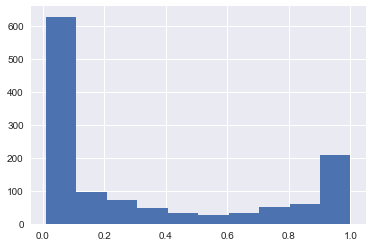

In [14]:
plt.hist(merged_full.loc[(merged_full['probas'] > 0.01), 'probas']);